In [8]:
import numpy as np
import matplotlib.pyplot as plt

# X represents the inputs to the gates
# W represents the weights at those gates 
class MultiplyGate:
    def forward(self,W, X):
        return np.dot(X, W)

    # W = weights, X = input from previous node, 
    def backward(self, W, X, dZ):
        dW = np.dot(np.transpose(X), dZ)
        dX = np.dot(dZ, np.transpose(W))
        return dW, dX

class AddGate:
    # X = input from previous node (in this case mul), b = input from other previous 
    # node. In this case, b is the intercept to add with X.dot(W)
    def forward(self, X, b):
        return X + b

    # X = input from previous node, b = input from previous node,
    # dZ = dF/dZ (F is loss function), derivative of next node's function
    # w.r.t the output from this node (i.e. dadd)
    def backward(self, X, b, dZ):
        dX = dZ * np.ones_like(X)
        db = np.dot(np.ones((1, dZ.shape[0]), dtype=np.float64), dZ)
        return db, dX
    
class Sigmoid:
    # X is input from previous node 
    def forward(self, X):
        return 1.0 / (1.0 + np.exp(-X))

    # X = input, ...
    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - output) * output * top_diff

class Tanh:
    # X = input
    def forward(self, X):
        return np.tanh(X)

    # input, ...
    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - np.square(output)) * top_diff

class Model:
    def __init__(self, layers_dim):
        self.b = []
        self.W = []
        for i in range(len(layers_dim)-1):
            self.W.append(np.random.randn(layers_dim[i], layers_dim[i+1]) / np.sqrt(layers_dim[i]))
            self.b.append(np.random.randn(layers_dim[i+1]).reshape(1, layers_dim[i+1]))

    def calculate_loss(self, X, y):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        return softmaxOutput.loss(input, y)

    def predict(self, X):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        probs = softmaxOutput.predict(input)
        return np.argmax(probs, axis=1)

    def train(self, X, y, num_passes=20000, epsilon=0.01, 
              reg_lambda=0.01, print_loss=False):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        for epoch in range(num_passes):
            # Forward propagation
            input = X
            forward = [(None, None, input)]
            for i in range(len(self.W)):
                mul = mulGate.forward(self.W[i], input)
                add = addGate.forward(mul, self.b[i])
                input = layer.forward(add)
                # Keep track of what we computed on forward pass
                # we will reuse it on the backward pass 
                forward.append((mul, add, input))

            # Back propagation: local gradient * current global gradient
            # see the computational graph here
            # https://github.com/pangolulu/neural-network-from-scratch
            # for d*/d* stuff to make sense 
            # dsoftmax/dtanh2
            # args: tanh, y from this layer
            dtanh = softmaxOutput.diff(forward[len(forward)-1][2], y)
            for i in range(len(forward)-1, 0, -1):
                # dtanh2/dadd2, ..., dtanh1/dadd1
                dadd = layer.backward(forward[i][1], dtanh)
                # (dadd2/db2, dadd2/dmul2), ..., (dadd1/db1, dadd1/dmul1)
                # takes args: mul, b, and dadd from this layer 
                db, dmul = addGate.backward(forward[i][0], self.b[i-1], dadd)
                # takes args: W, add, dmul from this layer
                dW, dtanh = mulGate.backward(self.W[i-1], forward[i-1][2], dmul)
                # Add regularization terms (b1 and b2 don't have regularization terms)
                dW += reg_lambda * self.W[i-1]
                # Gradient descent parameter update
                self.b[i-1] += -epsilon * db
                self.W[i-1] += -epsilon * dW

            if print_loss and epoch % 1000 == 0:
                print("Loss after iteration %i: %f" %(epoch, self.calculate_loss(X, y)))
                
class Softmax:
    # Just the softmax function 
    def predict(self, X):
        exp_scores = np.exp(X)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Cross entropy loss
    # - Sum_i y_i log(p_i)
    def loss(self, X, y):
        num_examples = X.shape[0]
        # p_i except for all examples
        probs = self.predict(X)
        # We only care about the probabilities for the correct class 
        # This is because y is one-hot encoded. The loss is zero for all 
        # non-correct class probabilities. No need to multiply by y_i b/c 
        # it just equals 1 
        correct_class_log_probs = -np.log(probs[range(num_examples), y])
        data_loss = np.sum(correct_class_log_probs)
        return 1./num_examples * data_loss

    # See https://deepnotes.io/softmax-crossentropy
    # for written out derivation of derivative of softmax 
    # and loss function 
    # dL/d output_i = p_i - y_i 
    # Since y is one-hot encoded usually, y_i = 1 
    # that's why we subtract 1 for the correct class 
    # probabilities below
    def diff(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        probs[range(num_examples), y] -= 1
        return probs

# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

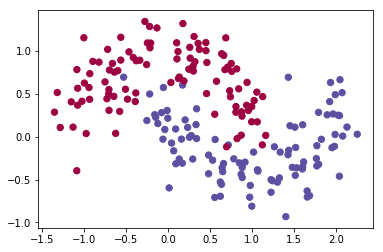

Loss after iteration 0: 0.700172
Loss after iteration 1000: 0.322804
Loss after iteration 2000: 0.192306
Loss after iteration 3000: 0.163452
Loss after iteration 4000: 0.161719
Loss after iteration 5000: 0.160974
Loss after iteration 6000: 0.160585
Loss after iteration 7000: 0.160363
Loss after iteration 8000: 0.160230
Loss after iteration 9000: 0.160147
Loss after iteration 10000: 0.160094
Loss after iteration 11000: 0.160060
Loss after iteration 12000: 0.160037
Loss after iteration 13000: 0.160022
Loss after iteration 14000: 0.160012
Loss after iteration 15000: 0.160005
Loss after iteration 16000: 0.160001
Loss after iteration 17000: 0.159998
Loss after iteration 18000: 0.159995
Loss after iteration 19000: 0.159994


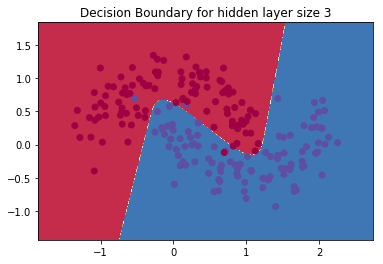

In [9]:
import sklearn
import sklearn.datasets
import sklearn.linear_model
import mlnn

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

layers_dim = [2, 3, 2]

model = mlnn.Model(layers_dim)
model.train(X, y, num_passes=20000, epsilon=0.01, reg_lambda=0.01, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary for hidden layer size 3")
plt.show()